# SARIMA Model - Predicting Small Merchants Revenue 

This notebook demonstrates how I developed the SARIMA model for predicting small merchants revenue changes in each county and made a forecast for the year of 2022. Please read my data cleaning notebook for data cleaning, descriptive statistics, and EDA. 

Contents of this notebook: 
1. Dickey-Fuller Test 

2. Modeling (Grid Search)

3. Model Validation 

3. Forecasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams
import itertools

import warnings
warnings.filterwarnings('ignore')

First, I read the data frame and I change the date to the datetime format and set date and zip code in indexes. 

In [2]:
# read data 
DF = pd.read_csv('Data/small_business.csv')

# set date into datetime frame
DF.date = pd.to_datetime(DF.date)


# set date and countyfips as index 
DF = DF.set_index(['countyfips', 'date']).sort_index() 

# report missing values 
DF

revenue_all  merchants_all  new_case_count  yearmonth
countyfips date                                                             
11001      2020-01-11       0.0302       -0.03570        0.000000     202001
           2020-01-18       0.0518        0.02580        0.000000     202001
           2020-01-25      -0.0529        0.00518        0.000000     202001
           2020-02-01      -0.0164        0.00889        0.000000     202002
           2020-02-08       0.0180        0.00438        0.000000     202002
...                            ...            ...             ...        ...
51683      2020-12-19      -0.4890       -0.37100       23.571429     202012
           2020-12-26      -0.2420       -0.27900       18.000000     202012
           2021-01-16      -0.5980       -0.33300       22.428571     202101
           2021-01-23      -0.3030       -0.37200       39.857143     202101
           2021-01-30      -0.2690       -0.34900       20.857143     202101

[864 rows x 4 columns]

In [3]:
print('Merchants revenue data covers from', DF.index.unique(level='date').min(), 'to' , DF.index.unique(level='date').max())
print('It includes', len(DF.index.unique(level='countyfips')), 'counties in Washington DC metro area.' )

Merchants revenue data covers from 2020-01-11 00:00:00 to 2021-01-30 00:00:00
It includes 16 counties in Washington DC metro area.


Before start analysis, I split my data set into train and test set. I use the 2021-12-01 as a cutoff date. As a consequence, train set has 47 observation and test set has 7 observations. 

In [4]:
# use 2021-11-01 as the cutoff point 
train = DF[DF.index.get_level_values('date') < '2020-12-01']

test = DF[DF.index.get_level_values('date') >= '2020-12-01']


In [5]:
print('Number of observation in train set for each county:', len(train.index.unique(level='date')))
print('Number of observation in test set for each county:', len(test.index.unique(level='date')))

Number of observation in train set for each county: 47
Number of observation in test set for each county: 7


# 1. Dickey-Fuller Test
I performed the Dickey-Fuller test for stationarity check of a time series. 
Below, I conducted the ADFuller test three times. The first test was with an original time series (i.e., no differencing, no moving average). And if a county fails this first test, I take a difference of a time series and redo the Dickey-Fuller test. If failed again, I take the second difference and try the ADFuller test. And any counties which failed the test with a second difference were dropped from this analysis. 

To run the test throughout all counties in my sample, first, I run the test and store the result in the data frame. And then, I evaluate the p-value and filter the zip code that failed the test. Zip codes that passed the first test are stored in 'diff0' list. Zip codes which need a second test with difference terms, I stored in 'diff1'.



In [6]:
# Check Dickey-Fuller test and report the p-values for each series

# To store the test result from each county
dtest = pd.DataFrame()
df_p = [] 
Fips = []

fips = train.index.unique(level='countyfips')
for x in fips:
    p_val_1 = adfuller(train.loc[(x, ),]['revenue_all'])[1] # extract p-value
    df_p.append(p_val_1)
    Fips.append(x) 
    
dtest['countyfips'] = Fips
dtest['Dickey_Fuller_p'] = df_p


dtest.head()

,countyfips,Dickey_Fuller_p
0,11001,0.000001
1,24009,0.005917
2,24017,0.089278
3,24021,0.266183
4,24031,0.148375


The cell below filters out the zip codes by p-value. If it's smaller than 0.05, the zipcode is stored in 'diff0'. If it's larger than 0.05, the zipcode is sotred in 'diff1'.

In [7]:
# Create a list of countyfips which passed the test as well as which did not pass the test. 

#List of zipcode which pass Dickey-Fuller test without taking difference 
diff0 = list(dtest[dtest.Dickey_Fuller_p <=0.05].countyfips)

# List a zipcode which failed Dickey-Fuller test, thus need to take difference
diff1 = list(dtest[dtest.Dickey_Fuller_p > 0.05].countyfips)


print(f'{len(diff0)} counties pass. {len(diff1)} counties does not pass the test, so redo the test after taking a difference.' )



11 counties pass. 5 counties does not pass the test, so redo the test after taking a difference.


For zip codes which failed the first dickey fuller test, I take a difference and redo the test. 

In [8]:
# Check Dickey-Fuller test and report the p-values for each county
# To store the test result from each county
dtest = pd.DataFrame()
df_p = [] 
Fips = []

# now I do test only for the counties which failed the earlier test 
fips = diff1
for x in diff1:
    p_val_1 = adfuller(train.diff().dropna().loc[(x, ),]['revenue_all'])[1] # extract p-value
    df_p.append(p_val_1)
    Fips.append(x) 
    
dtest['countyfips'] = Fips
dtest['Dickey_Fuller_p'] = df_p


dtest.head()

,countyfips,Dickey_Fuller_p
0,24017,1.274116e-17
1,24021,1.204300e-14
2,24031,7.681467e-09
3,24037,9.005668e-16
4,51610,4.701579e-14


In below, I filter the zip codes which failed the second DF test.

In [9]:
# Create a list of countyfips which passed the test as well as which did not pass the test. 

#List of zipcode which pass Dickey-Fuller test without taking difference 
diff1_1 = list(dtest[dtest.Dickey_Fuller_p <=0.05].countyfips)

# List a zipcode which failed Dickey-Fuller test, thus need to take difference
diff2 = list(dtest[dtest.Dickey_Fuller_p > 0.05].countyfips)


print(f'{len(diff1_1)} counties passed the test after differencing. {len(diff2)} counties does not pass the test.' )



5 counties passed the test after differencing. 0 counties does not pass the test.


Now, all counties passed the Dickey-Fuller stationary test with original series or one-time differenced series. 
Next, I start modeling.  


# 2. Modeling
## Rationality of using SARIMAX (seasonal ARIMA with exogenous variable)
I chose SARIMAX model with the COVID-19 daily new cases as exogenous variable. As shows in EDA section, small merchants revenue data is clearly influenced by the spread of COVID-19 cases in a region. So I picked SARIMAX model with the COVID-19 daily cases as exogenous variable.

### Pre-processing to train the model individually for each county

I train a model for each county individually. To streamline the modeling process, I create a list of a data frame. Each data frame is for one county. In this way, I can use for loop to run grid search, model validation, and forecasting for allcounties at once. I separate a list of a data frame by how many times I took the difference of a time series. Counties that passed the DF test without differencing, I stored in (diff0). Counties that took the first difference are in (diff1), and counties that took two times are in (diff2). This grouping helps me later when I roll back the differenced time series.

In [10]:
# Make a list of data frame for each county which takes original scale  
# To store the data frame for train set, test set, and total periods. 

train_diff0 = []
test_diff0 = []
all_diff0 = []

# Split the data by county and store in a list 
for x in diff0:
    train_diff0.append(pd.DataFrame(train.loc[(x, ),]))
    test_diff0.append(pd.DataFrame(test.loc[(x, ),]))
    all_diff0.append(pd.DataFrame(DF.loc[(x, ),]))


In [11]:
# Make a list of data frame for each county which takes a difference 
# To store original data frame (no differencing)  
train_orig1 = []
test_orig1 = []
all_orig1 = []
# To store differenced data frame
train_diff1 = []
test_diff1 = []
all_diff1 = []


for x in diff1_1:
    train_orig1.append(pd.DataFrame(train.loc[(x, ),]))
    test_orig1.append(pd.DataFrame(test.loc[(x, ),]))
    all_orig1.append(pd.DataFrame(DF.loc[(x, ),]))
    
    train_diff1.append(pd.DataFrame(train.loc[(x, ),].diff().dropna()))
    test_diff1.append(pd.DataFrame(test.loc[(x, ),].diff().dropna()))
    all_diff1.append(pd.DataFrame(DF.loc[(x, ),].diff().dropna()))

In [12]:
# rename 
diff1 = diff1_1

### Grid search of SARIMA parameters 
In a Grid search, I try all possible combination of p,d,q and P,D,Q in below. The seasonal frequency was set to 2, as I checked on the decomposition figures. And also, small merchants financial cycle, such as payment to employees, are often bimonthly.

In [13]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets (use 2 for frequency)
pdqs = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

I run grid search with p,d,q and P,D,Q parameters defined above. For the model selection, I use AIC scores.

I run the grid search separately for counties in diff0 and diff1.

In [14]:
# Grid search for counties in diff0 list. 

# Initialize an empty list to store results
ans = []

# For counties in diff0 run the following grid search. 
for df, name in zip(train_diff0, diff0):   
    # Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
    for comb in pdq:
        for combs in pdqs:
            try:
                #Fit traindata into SARIMAX from statsmodels 
                mod = SARIMAX(df['revenue_all'],
                              exog=df['new_case_count'], 
                              order=comb,
                              seasonal_order=combs, 
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
                
                #Get the results
                results = mod.fit()
                # Store the county name, pdq, PDQs, and AIC 
                ans.append([name, comb, combs, results.aic])
                
            except:
                continue

# Store all results to a data frame 
result_diff0 = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])


In below, I sort the data frame by lowest AIC, and store the best parameters for each county in best_para_diff0.

In [15]:
# Sort by lowest AIC 
best_para_diff0 = result_diff0.loc[result_diff0.groupby("name")["AIC"].idxmin()]

best_para_diff0

,name,pdq,pdqs,AIC
32,11001,"(1, 0, 0)","(0, 0, 0, 2)",-100.803963
112,24009,"(1, 1, 0)","(0, 0, 0, 2)",-75.391713
176,24033,"(1, 1, 0)","(0, 0, 0, 2)",-81.220018
253,51013,"(1, 1, 1)","(1, 0, 1, 2)",-79.247093
288,51059,"(1, 0, 0)","(0, 0, 0, 2)",-88.514144
368,51061,"(1, 1, 0)","(0, 0, 0, 2)",-92.438116
432,51107,"(1, 1, 0)","(0, 0, 0, 2)",-88.330270
501,51153,"(1, 1, 0)","(1, 0, 1, 2)",-81.263556
536,51187,"(0, 1, 1)","(0, 0, 0, 2)",-19.297778
613,51510,"(1, 0, 0)","(1, 0, 1, 2)",-48.875080


The table above report the the optimal set of parameters with the lowest AIC for each county in diff0 list. 

I do the same grid search for counties in diff1 list. 

In [16]:
# Grid search for counties in diff1. 

# Initialize an empty list to store results
ans_1 = []

# Run the grid search for diff1. train_diff1 is one differenced values. 
for df, name in zip(train_diff1, diff1):   
    # Iterate through all the combination of pdq and PDQs 
    for comb in pdq:
        for combs in pdqs:
            try:
                #Fit train data into SARIMAX from statsmodels 
                mod = SARIMAX(df['revenue_all'],
                              exog=df['new_case_count'], 
                              order=comb,
                              seasonal_order=combs, 
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
                
                #Get the results
                results = mod.fit()
                # Store the county name, pdq, PDQs, and AIC 
                ans_1.append([name, comb, combs, results.aic])
                
            except:
                continue

# Store all results to a data frame 
result_diff1 = pd.DataFrame(ans_1, columns = ['name','pdq','pdqs','AIC'])


I store all results from the grid search in to a data frame. And I sort by lowest AIC to find the best parameters for each county.


In [17]:


# Sort by lowest AIC 
best_para_diff1 = result_diff1.loc[result_diff1.groupby("name")["AIC"].idxmin()]

best_para_diff1

,name,pdq,pdqs,AIC
0,24017,"(0, 0, 0)","(0, 0, 0, 2)",-75.800718
68,24021,"(0, 0, 0)","(1, 0, 0, 2)",-87.437446
128,24031,"(0, 0, 0)","(0, 0, 0, 2)",-109.578367
224,24037,"(1, 0, 0)","(0, 0, 0, 2)",-73.246362
288,51610,"(1, 0, 0)","(0, 0, 0, 2)",-72.248484


The table above reports the optimal set of parameters with the lowest AIC for each county in diff1 list.

Next, I set the optimal set of parameters on SARIMAX model for each county and validate the model with a test set. 

# 3 Model Validation with test set
I check the model's prediction accuracy by comparing the prediction with the test time series. I use Root Mean Squared Error (RMSE) for the accuracy score.

In the cell below, I (1) fit the training data into the tuned model, (2) get prediction and confidence intervals and store the results in a data frame.  

In [18]:

def fitpredict(train, test, zip_df, best_para):   
    """
    Input: takes train data, test data, list of county ids, and parameters from grid search as inputs. 
    Output: predicted values and confirence intervals in one data frame
    
    """
    # To store the prediction 
    prediction = []
  
    for train_df, name in zip(train, zip_df):
        
        # 1. Fit the training data into the model
        
        # Get the optimal parameter from the grid serach results
        
        order = list(best_para.loc[best_para.name==name, 'pdq'].values)[0]
        seasonal_order = list(best_para.loc[best_para.name==name, 'pdqs'].values)[0]

        # Plug the optimal parameter values into a SARIMAX model
        sarimax = SARIMAX(train_df['revenue_all'],
                          exog=train_df['new_case_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        
        # Fit the model and print results
        output = sarimax.fit()        
      
        # 2. Predict using the train data 
        
        # Prediction period         
        start=len(train_df) 
        i = zip_df.index(name)
        end=len(train_df)+len(test[i])-1
        # input of exogenous variables 
        exog_forecast = test[i][['new_case_count']] 
        # plug in data for prediction and get the prediction
        pred = output.get_prediction(start=start, end=end, dynamic=True, exog= exog_forecast)
        # Get the confidence intervals for all predictions
        pred_conf = pred.conf_int()
        
        # Store prediction and confirence interval in one data frame to store.
        df_pred = pd.DataFrame(pred.predicted_mean)  
        df_conf = pd.DataFrame(pred_conf) 
        df_forecast = pd.concat([df_conf,df_pred], axis=1)
        prediction.append(df_forecast )
        
    return prediction



In [19]:
# Input train data, test data, zipcode, and bet parameters for each county into fitprediction function defined above. 
# 0, 1 indicates number of difference of time series, and zipcodes are stored by the number of difference.  

predict0 = fitpredict(train_diff0, test_diff0, diff0, best_para_diff0)
predict1 = fitpredict(train_diff1, test_diff1, diff1, best_para_diff1)


### Rolling back differenced time series. 
Before evaluating the predicted values, I need to bring the differenced data back to its original scale. In the following cell, I create a function to roll back the differenced data. For counties in diff1, I differenced the data one time, so the prediction is one-time difference. To roll back to the original scale, I sum up all differences and add them back to the last observed data of the training set. The below is the function to roll back for the differenced data.

In [20]:
# This function roll back the first order differencing to get the original scale  

def invert_diff(df_train, df_forecast):
    """Revert back the first differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy() 
    # cumulative sum of all forcast (= total sumn of changes since the last obeserved data) 
    df_fc['pred_cumsum'] = df_fc['predicted_mean'].cumsum()
    # add a column of the last observed data from the training. Here, this training data should be stored in the original scale. 
    df_fc['ob_last'] = df_train['revenue_all'].iloc[-1] 
    # add the acumulative change to the last observed data in original scale.
    df_fc['pred_commercial'] = df_fc['ob_last'] + df_fc['pred_cumsum'] 

    return df_fc

I store the rolled back prediction in a list.

In [21]:
predict1_rolled = []
for df_train, df_pre, name in zip(train_orig1, predict1, diff1):
    # apply invert difference function. 
    df_fc = invert_diff(df_train, df_pre)
    predict1_rolled.append(df_fc)


Using the rolled back prediction, I calculate RMSE. 
I define the RMSE calculation function separately for the first differenced group and no differenced group.


#### RMSE Function

In [22]:
def rmse1(test, predict, zip_df):
    summary_rmse = pd.DataFrame()
    RMSE1=[]
    Zipcode=[]
        
    for predict_df, name in zip(predict, zip_df):
        
        predict1 = predict_df['pred_commercial']
        i = zip_df.index(name)
        test1 = test[i][:-1]['revenue_all']
        rmse1 = np.sqrt(mean_squared_error(test1, predict1))
        Zipcode.append(name)
        RMSE1.append(rmse1)
    summary_rmse['Zipcode'] = Zipcode
    summary_rmse['RMSE'] = RMSE1
    return summary_rmse


In [23]:

def rmse0(test, predict, zip_df):
    summary_rmse = pd.DataFrame()
    RMSE1=[]
    Zipcode=[]
        
    for predict_df, name in zip(predict, zip_df):
        
        predict1 = predict_df['predicted_mean']
        i = zip_df.index(name)
        test1 = test[i]['revenue_all']
        rmse1 = np.sqrt(mean_squared_error(test1, predict1))
        Zipcode.append(name)
        RMSE1.append(rmse1)
    summary_rmse['Zipcode'] = Zipcode
    summary_rmse['RMSE'] = RMSE1
    return summary_rmse


Calculate RMSE for each group of counties, diff1 and diff0.

In [24]:
# Calcuate RMSE by using rmse function 
rmse_df0 = rmse0(test_diff0, predict0, diff0) 
rmse_df1 = rmse1(test_orig1, predict1_rolled, diff1) 

# Create one large dataframe wchich store the all RMSE 
rmse_df = rmse_df0.append(rmse_df1)
rmse_df

,Zipcode,RMSE
0,11001,0.053865
1,24009,0.116820
2,24033,0.117998
3,51013,0.208094
4,51059,0.134291
5,51061,0.141597
6,51107,0.073950
7,51153,0.126969
8,51187,0.517827
9,51510,0.224406


In [25]:
print(f'RMSE varies from 0 to {rmse_df.RMSE.max()}, with mean {rmse_df.RMSE.mean()}.' )
print(f'Since the marchant all changes ranges from {DF.merchants_all.min()} to {DF.merchants_all.max()}, the prediction is off about 10%.')



RMSE varies from 0 to 0.5178269460023391, with mean 0.1568104630834437.
Since the marchant all changes ranges from -0.555 to 0.141, the prediction is off about 10%.


#### Comparison with Naive model's RMSE
To evaluate SARIMA model, I compare with RMSE of naive model. Naive model for the time series is shifting the time series by one period. So, the next week's revenue change is equal to today's revenue change. 
In below, I calcuate RMSE of naive model for all zip codes.  

In [26]:
# Calculate a prediction by naive model 

def rmse_naive(data, zip_df):
    
    # to store RMSE for all zipcodes 
    rmse_df = pd.DataFrame()
    rmse_naive = []
    Zipcode = []
    
    for df, name in zip(data, zip_df):
        
        # Get revenue time series 
        series = df['revenue_all']
        # Naive model prediction  
        naive = series.shift(1)
        # Calculate RMSE 
        rmse = np.sqrt(mean_squared_error(series[1:], naive.dropna()))
        # store 
        rmse_naive.append(rmse)
        Zipcode.append(name)
    # store results in data frame 
    rmse_df['RMSE_naive'] = rmse_naive
    rmse_df['Zipcode'] = Zipcode
    
    return rmse_df

Using the anove function, I calculate the naive model RMSE for all counties, and store the results to the SARIMA's RMSE table.

In [27]:
# Calcuate naive model RMSE 
rmse_naive0 = rmse_naive(all_diff0, diff0) 
rmse_naive1 = rmse_naive(all_diff1, diff1)  

# Create one large dataframe wchich store the all RMSE 
rmse_naive_df = rmse_naive0.append(rmse_naive1)
rmse_naive_df

# Merge to SARIMA's rmse table 
rmse_df_1 = rmse_df.merge(rmse_naive_df, on='Zipcode', how='left')

rmse_df_1.head()

,Zipcode,RMSE,RMSE_naive
0,11001,0.053865,0.073294
1,24009,0.116820,0.108228
2,24033,0.117998,0.102150
3,51013,0.208094,0.121470
4,51059,0.134291,0.088175


In [28]:
# Comparison 
rmse_df_1.describe()


,Zipcode,RMSE,RMSE_naive
count,16.000000,16.000000,16.000000
mean,38533.250000,0.156810,0.134831
std,15232.400618,0.105308,0.045813
min,11001.000000,0.053865,0.073294
25%,24028.500000,0.116165,0.102189
50%,51036.000000,0.131825,0.116599
75%,51161.500000,0.152034,0.166723
max,51683.000000,0.517827,0.245173


The table above tells that mean and median of RMSE for SARIMA model is larger than naive model's RMSE. It means the naive model is better in predicting renevue changes than my SARIMA model.  

Below, I plot the prediction and original test data for Washington DC county. 

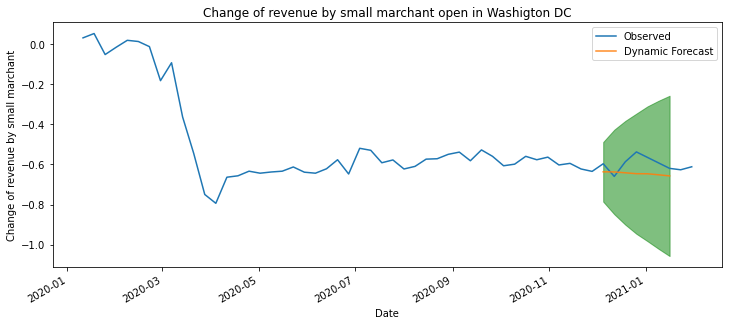

In [29]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 12, 5


# Plot observed values
ax = all_diff0[0]['revenue_all'].plot(label='Observed')

# Plot predicted values
predict0[0]['predicted_mean'].plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predict0[0].index,
                predict0[0]['lower revenue_all'],
                predict0[0]['upper revenue_all'], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Change of revenue by small marchant')
ax.set_title('Change of revenue by small marchant open in Washigton DC')
plt.legend()
#ax.set_xlim(['2021-05-01','2022-01-09'])

plt.show()

Observed data fluctuate, but the forecast stayed constant.


# 4. Forecasting

I forecast the merchant revenue for 2022 for all counties. First, I fit the model into an entire sample. Using that model, I make an out-of-sample prediction. Since my model needs an exogenous variable (covid-19 new cases for the forecasting period), I input hypothetical numbers. I assumed that by the end of 2022, the COID-19 new cases would be 0.

### Fit the model on the complete dataset
First, I create a hypothetical series for the COVID-19 new cases. I assume that the new daily case will drop incrementally and reach zero at the end of 2022. Below, I create hypothetical numbers for this scenarios.

Since I have a covid_19 new cases data till Jan 15, 2022. I use the observed data for Feb 2021 to Jan15, 2022. And beyond Jan15, I feed the hypothetical data which is based on the optimistic assumption that the covid new cases incrementally drop and reaches zero by the end of 2022.   

In [30]:
covid22 = pd.read_csv('Data/covid22opt.csv')

# set date into datetime frame
covid22.date = pd.to_datetime(covid22.date)

# set date and countyfips as index 
covid22 = covid22.set_index(['countyfips', 'date']).sort_index() 

covid22.head()

new_case_count
countyfips date                      
11001      2021-02-06      194.142857
           2021-02-13      157.142857
           2021-02-20      117.285714
           2021-02-27      112.857143
           2021-03-06      126.714286

Next, I store the above new dailty cases by county. 

In [31]:
# Store new cases by each county in diff0 
case1_diff0=[]

for x in diff0:
    dfx=covid22.loc[(x, ),]
    case1_diff0.append(dfx) 


# Store new cases by each county in diff0 
case1_diff1=[]

for x in diff1:
    dfx=covid22.loc[(x, ),]
    case1_diff1.append(dfx) 




Next, I fit the model on the complete dataset, feed the covid new cases data into the model, and and get a forecast for 2022 for each county. The following function is almost identical to the earlier fitprediction function with minor changes.

In [32]:

# Fit training data on the model with selected order. 
# Make prediction for the test period.   

def fitforecast(data, zip_df, best_para, newcases):   
    """
    Input: complete train data, list of county ids, and exogenous data. 
    Output: predictions
    
    """
    # To store the prediction 
    prediction = []
  
    for df, name, newcase in zip(data, zip_df, newcases):
        
        # 1. Fit the training data into the model
        
        # Get the optimal parameter from the grid serach results        
        order = list(best_para.loc[best_para.name==name, 'pdq'].values)[0]
        seasonal_order = list(best_para.loc[best_para.name==name, 'pdqs'].values)[0]

        # Plug the optimal parameter values into a SARIMAX model
        sarimax = SARIMAX(df['revenue_all'],
                          exog=df['new_case_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        
        # Fit the model and print results
        output = sarimax.fit()        
 
        # 2. Predict using the train data 
        # Get forecast 360 steps ahead in future
        pred = output.get_forecast(steps=100, exog=newcase) # dynamic=True,
        
        # forecasting week 
        week = pd.date_range('2021-02-06','2022-12-31', freq='W-SAT')
        
        
        # Get confidence intervals of forecasts
        pred_conf = pred.conf_int()
        
        # Store prediction and confirence interval in one data frame to store.
        df_pred = pd.DataFrame(pred.predicted_mean)  #, index=test[i].index
        df_conf = pd.DataFrame(pred_conf)  #, index=test[i].index
        df_forecast = pd.concat([df_conf,df_pred], axis=1)
        df_forecast.reset_index(inplace=True)
        df_forecast.drop(['index'], axis=1, inplace=True)
        df_forecast.index=week
        prediction.append(df_forecast )
        
    return prediction



Apply the function and get prediction. 

In [33]:
# Get forecast for counties in diff0 and diff1. 
forecast0 = fitforecast(all_diff0, diff0, best_para_diff0, case1_diff0)
forecast1 = fitforecast(all_diff1, diff1, best_para_diff1, case1_diff1)


#### Rolling back differenced time series. 
Using invert_diff function created earlier, I roll back the differenced time series to its original scale. 

In [34]:
# Roll back the forecast 
forecast1_rolled = []
for df, df_pre, name in zip(all_orig1, forecast1, diff1):
    # apply invert difference function. 
    df_fc = invert_diff(df, df_pre)
    forecast1_rolled.append(df_fc)



#### Lastly, I create a data frame that stores observed and forecast data for all counties in one table.


First, I create a data frame from a list that stores forecasted values for each county. A data frame's row is county fips, a column is a date, and each value is a predicted mobility index. Second, I create a data frame of the historical data in the same setting; row is county ID (countyfips), and column is the date. And merge two data frames using countyfips as a key value.


In [36]:
# 1. Convert a list of forecast into a table. 

# for county in diff1 
fc_df1=pd.DataFrame()
for df_pre, name in zip(forecast1, diff1):
    fc_df1[name]=forecast1[diff1.index(name)]['predicted_mean']

fd_merge1 = fc_df1.T

# for county in diff0 
fc_df=pd.DataFrame()

for df_pre, name in zip(forecast0, diff0):
    fc_df[name]=forecast0[diff0.index(name)]['predicted_mean']

fd_merge = fc_df.T

# merhe both dataset into one 
fd_merge2 = fd_merge.append(fd_merge1)

# 2. reshape a original dataset 
DF1 = DF
DF2 = DF1.unstack()['revenue_all']

DF2.reset_index(inplace=True)

In [37]:
# 3. merge the forecast df to original df

# reset index before merge 
fd_merge2.reset_index(inplace=True)

DF3 = DF2.merge(fd_merge2, how='left', left_on='countyfips', right_on='index')
DF3.head()

,countyfips,2020-01-11 00:00:00,2020-01-18 00:00:00,2020-01-25 00:00:00,2020-02-01 00:00:00,2020-02-08 00:00:00,2020-02-15 00:00:00,2020-02-22 00:00:00,2020-02-29 00:00:00,2020-03-07 00:00:00,...,2022-10-29 00:00:00,2022-11-05 00:00:00,2022-11-12 00:00:00,2022-11-19 00:00:00,2022-11-26 00:00:00,2022-12-03 00:00:00,2022-12-10 00:00:00,2022-12-17 00:00:00,2022-12-24 00:00:00,2022-12-31 00:00:00
0,11001,0.0302,0.0518,-0.052900,-0.0164,0.01800,0.01210,-0.0134,-0.1830,-0.0938,...,-0.683007,-0.665478,-0.647949,-0.630420,-0.612891,-0.595362,-0.577832,-0.560303,-0.542774,-5.252450e-01
1,24009,0.0136,0.0502,-0.064800,-0.0107,0.13300,-0.08860,0.0193,-0.0695,0.0243,...,-0.336659,-0.350139,-0.363620,-0.377101,-0.390582,-0.404062,-0.417543,-0.431024,-0.444505,-4.579856e-01
2,24017,0.0810,-0.0426,-0.051600,-0.1300,-0.10700,0.13500,0.0449,-0.1890,-0.0864,...,-0.191308,-0.170051,-0.148795,-0.127538,-0.106282,-0.085026,-0.063769,-0.042513,-0.021256,0.000000e+00
3,24021,-0.0298,-0.1720,0.080300,0.0907,-0.05530,0.03820,0.0189,-0.1040,0.0323,...,-0.085966,-0.076414,-0.066862,-0.057310,-0.047759,-0.038207,-0.028655,-0.019103,-0.009552,8.862213e-37
4,24031,-0.0524,0.0941,0.000102,-0.0650,-0.00748,-0.00279,0.0802,-0.0814,-0.0930,...,-0.254841,-0.226525,-0.198210,-0.169894,-0.141578,-0.113263,-0.084947,-0.056631,-0.028316,0.000000e+00


Lastly, I create a data frame which stores obserbed data and forecast data for all counties in a same table. 

Finally, I transpose the data frame to columns = county, and rows = date, and save in csv.  

In [38]:
# Change countyfips from integer to string 

DF3.countyfips = DF3.countyfips.astype(str)

# set county fips as index 
DF3.set_index(DF3.countyfips,  inplace=True)
DF3.drop(['countyfips'], axis=1, inplace=True)

# Transform wide format to long format 
df3 = DF3.reset_index()
df3 = pd.melt(df3, id_vars=['countyfips'], var_name = 'date', value_name='revenue_all')

# calculate the changes. 
df3['yoy_change'] = df3.groupby(['countyfips'])['revenue_all'].pct_change(4)

# Assign columns for post modeling analysis 
df3.date = df3.date.astype('str')
df3['year'] = df3.date.str[:4]
df3['month'] =df3.date.str[5:7]
df3['yearmonth']=df3.date.str[:7]
df3['day'] =df3.date.str[8:10]
df3['Date'] =df3.date.str[0:10]
df3.head()

,countyfips,date,revenue_all,yoy_change,year,month,yearmonth,day,Date
0,11001,2020-01-11 00:00:00,0.0302,NaN,2020,01,2020-01,11,2020-01-11
1,24009,2020-01-11 00:00:00,0.0136,NaN,2020,01,2020-01,11,2020-01-11
2,24017,2020-01-11 00:00:00,0.0810,NaN,2020,01,2020-01,11,2020-01-11
3,24021,2020-01-11 00:00:00,-0.0298,NaN,2020,01,2020-01,11,2020-01-11
4,24031,2020-01-11 00:00:00,-0.0524,NaN,2020,01,2020-01,11,2020-01-11


## Save the data frame

In [39]:
# Save
df3.to_csv('Data/revenue_forecast.csv', index=False)